# Chapter 12: Music Generation with MuseGAN

This chapter covers

* Music representation using musical instrument digital interface (MIDI)  
* Treating music generation as an object creation problem similar to image generation
* Building and training a generative adversarial network (GAN) to generate music
* Generating music using the trained MuseGAN model

Up to now, we have successfully generated shapes, numbers, images, and text. In this chapter and the next, we will explore two different approaches to create lifelike music. This chapter will apply the techniques from image GANs, treating a piece of music as a multi-dimensional object akin to an image. The generator will produce a complete piece of music and submit it to the critic for evaluation. The generator will then modify the music based on the critic's feedback until it closely resembles real music from the training dataset. In the nect chapter, we will treat music as a sequence of notes, employing natural language processing techniques. We will use a GPT-style Transformer to predict the most probable note in a sequence based on the preceding notes. This Transformer will generate a long sequence of notes that can be converted into realistic-sounding music.

The field of music generation using artificial intelligence (AI) has gained significant attention, with MuseGAN being a prominent model, which is introduced by Dong, Hsiao, Yang, and Yang in 2017.  MuseGAN is a deep neural network that utilizes Generative Adversarial Networks (GANs) to create multi-track music, with the word Muse signifying the creative inspiration behind music. The model is adept at understanding the complex interactions between different tracks that represent different musical instruments or different voices (which is the case in our training data). As a result, MuseGAN can generate compositions that are harmonious and cohesive.

MuseGAN, similar to other GAN models, consists of two primary components: the generator and the critic (serving as the discriminator, utilizing the Wasserstein distance with gradient penalty as discussed in Chapter 5). The generator's task is to generate music, whereas the critic assesses the music's quality and offers feedback to the generator. This adversarial interaction enables the generator to gradually improve, leading to the creation of more realistic and appealing music. 

In this chapter, you'll first explore how to represent a piece of music as a multi-dimensional object. Specifically, each piece of music in our training set is structured with a (4, 2, 16, 84) shape: this means there are four music tracks, with each track consisting of two bars, each bar containing 16 steps, and each step capable of playing one of the 84 different notes. A track is essentially an individual line of music or sound, which can be a different instrument such as piano, bass, or drums, or a different voice such as soprano, alto, tenor, or bass. When composing a track in electronic music, you typically organize it into bars, subdivide each bar into steps for finer control over rhythm, and then assign a specific note to each step to craft your melodies and rhythms.

The style of the music generated by our MuseGAN will be influenced by the training data we use. In this case, we'll be training our GAN with The JSB Chorales dataset, which is a collection of harmonized chorales composed by Johann Sebastian Bach, arranged for four tracks. These chorales have been converted into a piano roll representation, a method used for visualizing and encoding music, especially for digital processing purposes. You'll learn how to transform a piece of music represented in the shape of (4, 2, 16, 84) into a musical instrument digital interface (MIDI) file, which can then be played on your computer.

While the generator uses just one single noise vector from the latent space to generate different formats of content such as shapes, numbers, and images in earlier chapters, the generator in MuseGAN will use four nose vectors when producing a piece of music. The use of four separate noise vectors (chords, style, melody, and groove, which we’ll explain in detail later in this chapter) is a design choice that allows for greater control and diversity in the music generation process. Each of these noise vectors represents a different aspect of music, and by manipulating them individually, the model can generate more complex and nuanced compositions.

Once the model has been trained, we'll discard the critic network, a common practice in GAN models. We'll then utilize the trained generator to produce music pieces by inputting four noise vectors from the latent space. The music generated in this way closely mirrors the style of Bach. 

The MuseGAN model is proposed by Dong, Hsiao, Yang, and Yang in 2017 (https://arxiv.org/abs/1709.06298). The code in this chapter is adapted from Azamat Kanametov's GitHub repository (https://github.com/akanametov/musegan). 

## 1	Digital music representation 

In [1]:
# Need to install the following 
!pip install music21

In [2]:
# Downlaod example.midi from this repo; play on your computer
# It should sound like this (this is what training data sounds like)
import IPython.display as ipd
ipd.Audio("https://gattonweb.uky.edu/faculty/lium/gai/example.mp3") 

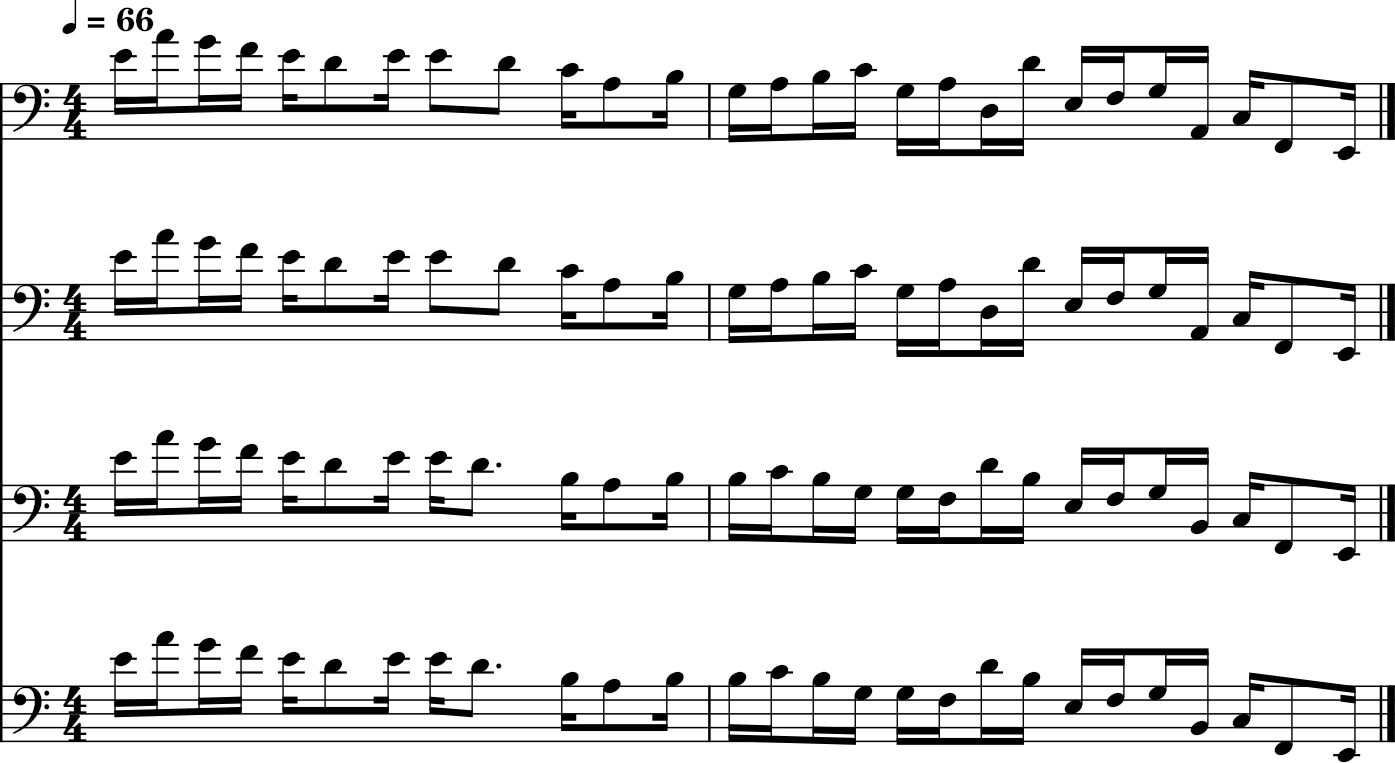

In [3]:
'''
download and install MuseScore4 https://musescore.org/en/download
or a later version; if you are using a later version, say,
MuseScore5, change 4 to 5 in this code cell

####################
if you are using MAC
path='/Applications/MuseScore 4.app/Contents/MacOS/mscore'
#######################
if you are using Linux, change path to 
path='/home/[user name]/.local/bin/mscore4portable'
my username is mark, so I used 
path='/home/mark/.local/bin/mscore4portable'
'''
%matplotlib inline

from music21 import midi, environment

mf = midi.MidiFile()    
mf.open("files/example.midi")    
mf.read()
mf.close()
stream = midi.translate.midiFileToStream(mf)

us = environment.Environment() 
path = r'C:\Program Files\MuseScore 4\bin\MuseScore4.exe'
us['musescoreDirectPNGPath'] = path
stream.show()

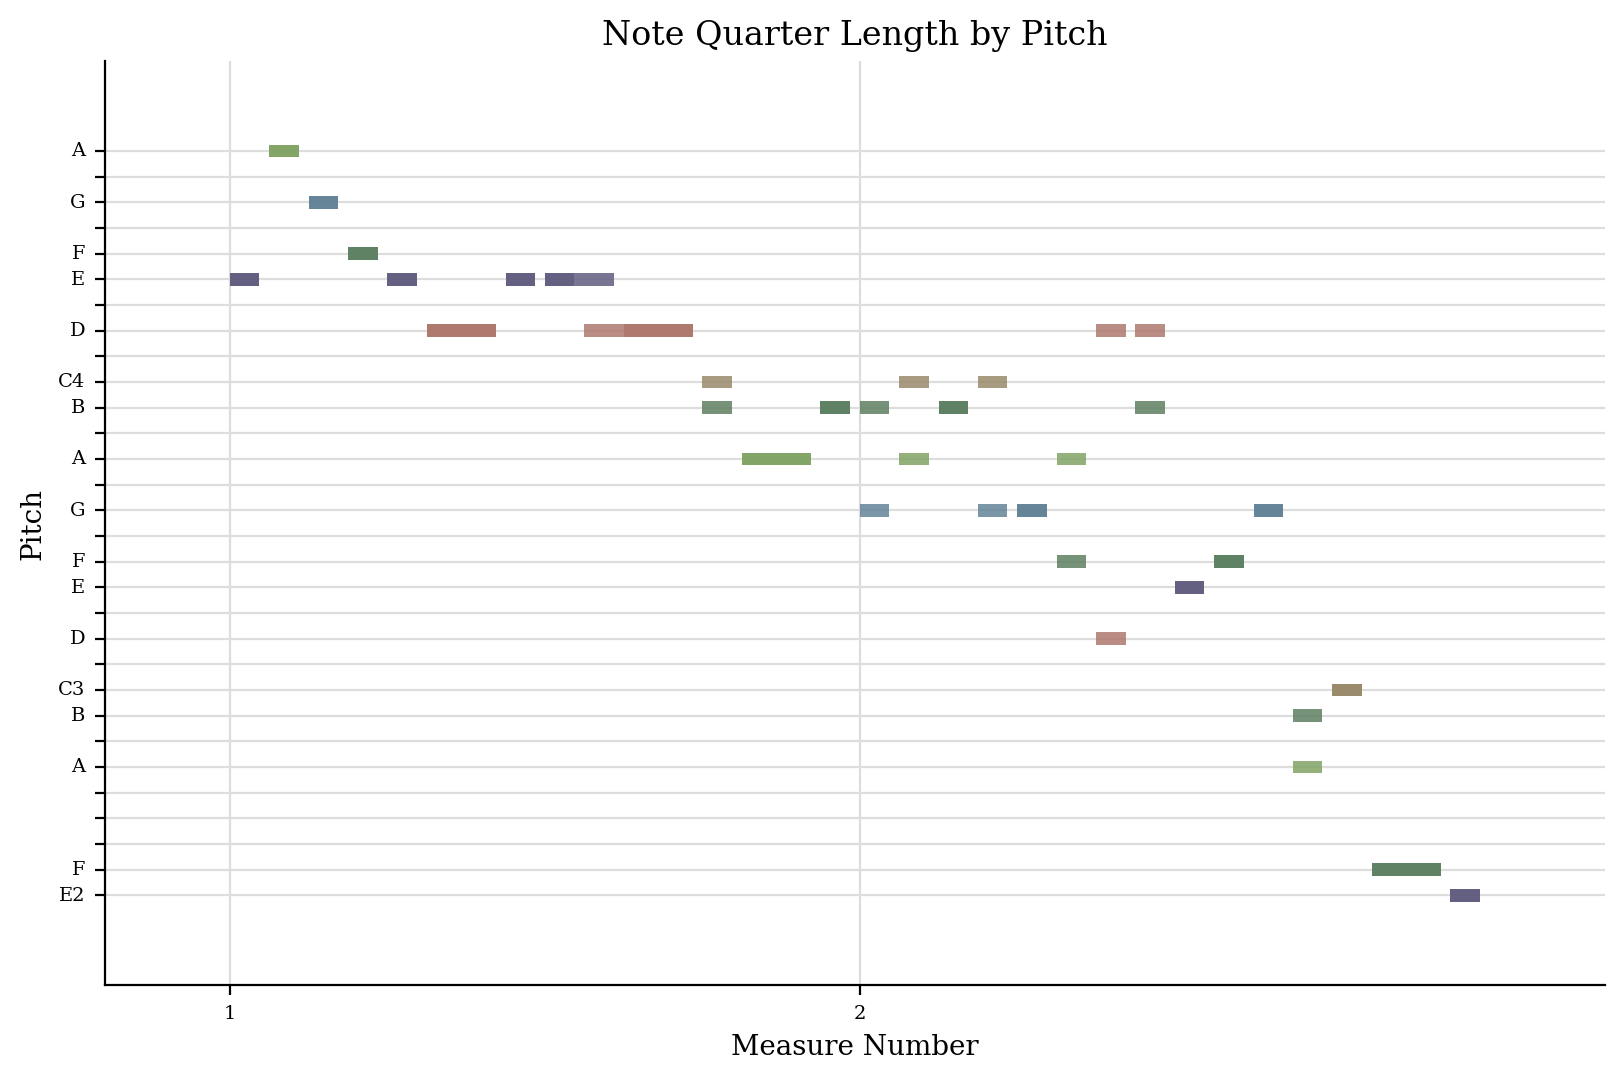

In [4]:
stream.plot()

In [5]:
for n in stream.recurse().notes:
    print(n.offset, n.pitches) 

0.0 (<music21.pitch.Pitch E4>,)
0.25 (<music21.pitch.Pitch A4>,)
0.5 (<music21.pitch.Pitch G4>,)
0.75 (<music21.pitch.Pitch F4>,)
1.0 (<music21.pitch.Pitch E4>,)
1.25 (<music21.pitch.Pitch D4>,)
1.75 (<music21.pitch.Pitch E4>,)
2.0 (<music21.pitch.Pitch E4>,)
2.5 (<music21.pitch.Pitch D4>,)
3.0 (<music21.pitch.Pitch C4>,)
3.25 (<music21.pitch.Pitch A3>,)
3.75 (<music21.pitch.Pitch B3>,)
0.0 (<music21.pitch.Pitch G3>,)
0.25 (<music21.pitch.Pitch A3>,)
0.5 (<music21.pitch.Pitch B3>,)
0.75 (<music21.pitch.Pitch C4>,)
1.0 (<music21.pitch.Pitch G3>,)
1.25 (<music21.pitch.Pitch A3>,)
1.5 (<music21.pitch.Pitch D3>,)
1.75 (<music21.pitch.Pitch D4>,)
2.0 (<music21.pitch.Pitch E3>,)
2.25 (<music21.pitch.Pitch F3>,)
2.5 (<music21.pitch.Pitch G3>,)
2.75 (<music21.pitch.Pitch A2>,)
3.0 (<music21.pitch.Pitch C3>,)
3.25 (<music21.pitch.Pitch F2>,)
3.75 (<music21.pitch.Pitch E2>,)
0.0 (<music21.pitch.Pitch E4>,)
0.25 (<music21.pitch.Pitch A4>,)
0.5 (<music21.pitch.Pitch G4>,)
0.75 (<music21.pitch.Pitc

In [6]:
for n in stream.recurse().notes:
    print(n.offset,n.pitches[0].midi)

0.0 64
0.25 69
0.5 67
0.75 65
1.0 64
1.25 62
1.75 64
2.0 64
2.5 62
3.0 60
3.25 57
3.75 59
0.0 55
0.25 57
0.5 59
0.75 60
1.0 55
1.25 57
1.5 50
1.75 62
2.0 52
2.25 53
2.5 55
2.75 45
3.0 48
3.25 41
3.75 40
0.0 64
0.25 69
0.5 67
0.75 65
1.0 64
1.25 62
1.75 64
2.0 64
2.5 62
3.0 60
3.25 57
3.75 59
0.0 55
0.25 57
0.5 59
0.75 60
1.0 55
1.25 57
1.5 50
1.75 62
2.0 52
2.25 53
2.5 55
2.75 45
3.0 48
3.25 41
3.75 40
0.0 64
0.25 69
0.5 67
0.75 65
1.0 64
1.25 62
1.75 64
2.0 64
2.25 62
3.0 59
3.25 57
3.75 59
0.0 59
0.25 60
0.5 59
0.75 55
1.0 55
1.25 53
1.5 62
1.75 59
2.0 52
2.25 53
2.5 55
2.75 47
3.0 48
3.25 41
3.75 40
0.0 64
0.25 69
0.5 67
0.75 65
1.0 64
1.25 62
1.75 64
2.0 64
2.25 62
3.0 59
3.25 57
3.75 59
0.0 59
0.25 60
0.5 59
0.75 55
1.0 55
1.25 53
1.5 62
1.75 59
2.0 52
2.25 53
2.5 55
2.75 47
3.0 48
3.25 41
3.75 40


# 2	A blueprint for music generation 
# 3	Prepare the training data for MuseGAN

## 3.1. Download the training data

In [7]:
from torch.utils.data import DataLoader
from utils.midi_util import MidiDataset

dataset = MidiDataset('files/Jsb16thSeparated.npz')
first_song=dataset[0]
print(first_song.shape)
loader = DataLoader(dataset, batch_size=64, 
                        shuffle=True, drop_last=True)

torch.Size([4, 2, 16, 84])


In [8]:
flat=first_song.reshape(-1,)
print(set(flat.tolist()))

{1.0, -1.0}


## 3.2	Convert multi-dimensional objects to music pieces

In [9]:
import numpy as np
from music21 import note, stream, duration, tempo

parts = stream.Score()
parts.append(tempo.MetronomeMark(number=66))
max_pitches = np.argmax(first_song, axis=-1)
midi_note_score = max_pitches.reshape([2 * 16, 4])
print(midi_note_score)

tensor([[74, 74, 74, 74],
        [75, 75, 75, 75],
        [77, 77, 77, 77],
        [77, 77, 77, 77],
        [75, 75, 75, 75],
        [74, 74, 74, 74],
        [72, 72, 72, 72],
        [72, 72, 72, 72],
        [70, 70, 70, 70],
        [70, 70, 70, 70],
        [69, 69, 69, 69],
        [70, 70, 69, 69],
        [67, 67, 69, 69],
        [70, 70, 70, 70],
        [69, 69, 69, 69],
        [69, 69, 69, 69],
        [65, 65, 65, 65],
        [58, 58, 60, 60],
        [62, 62, 62, 62],
        [62, 62, 62, 62],
        [63, 63, 63, 63],
        [65, 65, 65, 65],
        [65, 65, 65, 65],
        [65, 65, 65, 65],
        [58, 58, 58, 58],
        [55, 55, 55, 55],
        [50, 50, 50, 50],
        [55, 55, 55, 55],
        [48, 48, 48, 48],
        [46, 46, 46, 46],
        [53, 53, 53, 53],
        [53, 53, 53, 53]])


In [10]:
for i in range(4):
    last_x = int(midi_note_score[:, i][0])
    s = stream.Part()
    dur = 0
    for idx, x in enumerate(midi_note_score[:, i]):
        x = int(x)
        if (x != last_x or idx % 4 == 0) and idx > 0:
            n = note.Note(last_x)
            n.duration = duration.Duration(dur)
            s.append(n)
            dur = 0
        last_x = x
        dur = dur + 0.25
    n = note.Note(last_x)
    n.duration = duration.Duration(dur)
    s.append(n)
    parts.append(s)  
parts.write("midi","files/first_song.midi")

'files/first_song.midi'

In [11]:
# Answer to exercise 12.1
second_song=dataset[1]
parts = stream.Score()
parts.append(tempo.MetronomeMark(number=66))
max_pitches = np.argmax(second_song, axis=-1)
midi_note_score = max_pitches.reshape([2 * 16, 4])
for i in range(4):
    last_x = int(midi_note_score[:, i][0])
    s = stream.Part()
    dur = 0
    for idx, x in enumerate(midi_note_score[:, i]):
        x = int(x)
        if (x != last_x or idx % 4 == 0) and idx > 0:
            n = note.Note(last_x)
            n.duration = duration.Duration(dur)
            s.append(n)
            dur = 0
        last_x = x
        dur = dur + 0.25
    n = note.Note(last_x)
    n.duration = duration.Duration(dur)
    s.append(n)
    parts.append(s)  
parts.write("midi","files/second_song.midi")

'files/second_song.midi'

# 4.  Build A MuseGAN

## 2.1. A Critic in MuseGAN

Defined in the local module MuseGAN_util.py
```python
class MuseCritic(nn.Module):
    def __init__(self,hid_channels=128,hid_features=1024,
        out_features=1,n_tracks=4,n_bars=2,n_steps_per_bar=16,
        n_pitches=84):
        super().__init__()
        self.n_tracks = n_tracks
        self.n_bars = n_bars
        self.n_steps_per_bar = n_steps_per_bar
        self.n_pitches = n_pitches
        in_features = 4 * hid_channels if n_bars == 2\
            else 12 * hid_channels
        self.seq = nn.Sequential(
            nn.Conv3d(self.n_tracks, hid_channels, 
                      (2, 1, 1), (1, 1, 1), padding=0),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv3d(hid_channels, hid_channels, 
              (self.n_bars - 1, 1, 1), (1, 1, 1), padding=0),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv3d(hid_channels, hid_channels, 
                      (1, 1, 12), (1, 1, 12), padding=0),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv3d(hid_channels, hid_channels, 
                      (1, 1, 7), (1, 1, 7), padding=0),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv3d(hid_channels, hid_channels, 
                      (1, 2, 1), (1, 2, 1), padding=0),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv3d(hid_channels, hid_channels, 
                      (1, 2, 1), (1, 2, 1), padding=0),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv3d(hid_channels, 2 * hid_channels, 
                      (1, 4, 1), (1, 2, 1), padding=(0, 1, 0)),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Conv3d(2 * hid_channels, 4 * hid_channels, 
                      (1, 3, 1), (1, 2, 1), padding=(0, 1, 0)),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Flatten(),
            nn.Linear(in_features, hid_features),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Linear(hid_features, out_features))
    def forward(self, x):  
        return self.seq(x)
```

## 4.2	A generator in MuseGAN

Defined in the local module MuseGAN_util.py
```python
class TemporalNetwork(nn.Module):
    def __init__(self,z_dimension=32,hid_channels=1024,n_bars=2):
        super().__init__()
        self.n_bars = n_bars
        self.net = nn.Sequential(
            Reshape(shape=[z_dimension, 1, 1]),
            nn.ConvTranspose2d(z_dimension,hid_channels,
                kernel_size=(2, 1),stride=(1, 1),padding=0,),
            nn.BatchNorm2d(hid_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(hid_channels,z_dimension,
                kernel_size=(self.n_bars - 1, 1),stride=(1, 1),
                padding=0,),
            nn.BatchNorm2d(z_dimension),
            nn.ReLU(inplace=True),
            Reshape(shape=[z_dimension, self.n_bars]),)
    def forward(self, x):
        return self.net(x)
```

Defined in the local module MuseGAN_util.py
```python

class BarGenerator(nn.Module):
    def __init__(self,z_dimension=32,hid_features=1024,hid_channels=512,
        out_channels=1,n_steps_per_bar=16,n_pitches=84):
        super().__init__()
        self.n_steps_per_bar = n_steps_per_bar
        self.n_pitches = n_pitches
        self.net = nn.Sequential(
            nn.Linear(4 * z_dimension, hid_features),
            nn.BatchNorm1d(hid_features),
            nn.ReLU(inplace=True),
            Reshape(shape=[hid_channels,hid_features//hid_channels,1]),
            nn.ConvTranspose2d(hid_channels,hid_channels,
               kernel_size=(2, 1),stride=(2, 1),padding=0),
            nn.BatchNorm2d(hid_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(hid_channels,hid_channels // 2,
                kernel_size=(2, 1),stride=(2, 1),padding=0),
            nn.BatchNorm2d(hid_channels // 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(hid_channels // 2,hid_channels // 2,
                kernel_size=(2, 1),stride=(2, 1),padding=0),
            nn.BatchNorm2d(hid_channels // 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(hid_channels // 2,hid_channels // 2,
                kernel_size=(1, 7),stride=(1, 7),padding=0),
            nn.BatchNorm2d(hid_channels // 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(hid_channels // 2,out_channels,
                kernel_size=(1, 12),stride=(1, 12),padding=0),
            Reshape([1, 1, self.n_steps_per_bar, self.n_pitches]))
    def forward(self, x):
        return self.net(x)
```

Defined in the local module MuseGAN_util.py
```python
class MuseGenerator(nn.Module):
    def __init__(self,z_dimension=32,hid_channels=1024,
        hid_features=1024,out_channels=1,n_tracks=4,
        n_bars=2,n_steps_per_bar=16,n_pitches=84):
        super().__init__()
        self.n_tracks = n_tracks
        self.n_bars = n_bars
        self.n_steps_per_bar = n_steps_per_bar
        self.n_pitches = n_pitches
        self.chords_network=TemporalNetwork(z_dimension, 
                            hid_channels, n_bars=n_bars)
        self.melody_networks = nn.ModuleDict({})
        for n in range(self.n_tracks):
            self.melody_networks.add_module(
                "melodygen_" + str(n),
                TemporalNetwork(z_dimension, 
                 hid_channels, n_bars=n_bars))
        self.bar_generators = nn.ModuleDict({})
        for n in range(self.n_tracks):
            self.bar_generators.add_module(
                "bargen_" + str(n),BarGenerator(z_dimension,
            hid_features,hid_channels // 2,out_channels,
            n_steps_per_bar=n_steps_per_bar,n_pitches=n_pitches))
    def forward(self,chords,style,melody,groove):
        chord_outs = self.chords_network(chords)
        bar_outs = []
        for bar in range(self.n_bars):
            track_outs = []
            chord_out = chord_outs[:, :, bar]
            style_out = style
            for track in range(self.n_tracks):
                melody_in = melody[:, track, :]
                melody_out = self.melody_networks["melodygen_"\
                          + str(track)](melody_in)[:, :, bar]
                groove_out = groove[:, track, :]
                z = torch.cat([chord_out, style_out, melody_out,\
                               groove_out], dim=1)
                track_outs.append(self.bar_generators["bargen_"\
                                          + str(track)](z))
            track_out = torch.cat(track_outs, dim=1)
            bar_outs.append(track_out)
        out = torch.cat(bar_outs, dim=2)
        return out
```    

## 4.3. Optimizers and the Loss Function

In [12]:
import torch
from utils.MuseGAN_util import (
    init_weights, MuseGenerator, MuseCritic)

device = "cuda" if torch.cuda.is_available() else "cpu"
generator = MuseGenerator(z_dimension=32, hid_channels=1024, 
              hid_features=1024, out_channels=1).to(device)
critic = MuseCritic(hid_channels=128,
                    hid_features=1024,
                    out_features=1).to(device)
generator = generator.apply(init_weights)
critic = critic.apply(init_weights)

Defined in the local module MuseGAN_util.py
```python
def loss_fn(pred,target):
    return -torch.mean(pred*target)
```

Defined in the local module MuseGAN_util.py
```python
class GradientPenalty(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, inputs, outputs):
        grad = torch.autograd.grad(
            inputs=inputs,
            outputs=outputs,
            grad_outputs=torch.ones_like(outputs),
            create_graph=True,
            retain_graph=True,
        )[0]
        grad_=torch.norm(grad.view(grad.size(0),-1),p=2,dim=1)
        penalty = torch.mean((1. - grad_) ** 2)
        return penalty
```    

In [13]:
lr = 0.001
g_optimizer = torch.optim.Adam(generator.parameters(),
                               lr=lr, betas=(0.5, 0.9))
c_optimizer = torch.optim.Adam(critic.parameters(),
                               lr=lr, betas=(0.5, 0.9))

# 5	Train the MuseGAN to generate music
## 5.1	Train the MuseGAN

In [14]:
from utils.MuseGAN_util import loss_fn, GradientPenalty

batch_size=64
repeat=5
display_step=10
epochs=500
alpha=torch.rand((batch_size,1,1,1,1)).requires_grad_().to(device)
gp=GradientPenalty()

def noise():
    chords = torch.randn(batch_size, 32).to(device)
    style = torch.randn(batch_size, 32).to(device)
    melody = torch.randn(batch_size, 4, 32).to(device)
    groove = torch.randn(batch_size, 4, 32).to(device)
    return chords,style,melody,groove

In [15]:
def train_epoch():
    e_gloss = 0
    e_closs = 0
    for real in loader:
        real = real.to(device)
        # Train Critic
        for _ in range(repeat):
            chords,style,melody,groove=noise()
            c_optimizer.zero_grad()
            with torch.no_grad():
                fake = generator(chords, style, melody,groove).detach()
            realfake = alpha * real + (1 - alpha) * fake
            fake_pred = critic(fake)
            real_pred = critic(real)
            realfake_pred = critic(realfake)
            fake_loss =  loss_fn(fake_pred,-torch.ones_like(fake_pred))
            real_loss = loss_fn(real_pred,torch.ones_like(real_pred))
            penalty = gp(realfake, realfake_pred)
            closs = fake_loss + real_loss + 10 * penalty
            closs.backward(retain_graph=True)
            c_optimizer.step()
            e_closs += closs.item() / (repeat*len(loader))
        # train generator
        g_optimizer.zero_grad()
        chords,style,melody,groove=noise()
        fake = generator(chords, style, melody, groove)
        fake_pred = critic(fake)
        gloss = loss_fn(fake_pred, torch.ones_like(fake_pred))
        gloss.backward()
        g_optimizer.step()
        e_gloss += gloss.item() / len(loader)
    return e_gloss, e_closs

In [16]:
for epoch in range(1,epochs+1):
    e_gloss, e_closs = train_epoch()
    if epoch % display_step == 0:
        print(f"Epoch {epoch}, G loss {e_gloss} C loss {e_closs}")

In [17]:
torch.save(generator.state_dict(),'files/MuseGAN_G.pth')

## 5.2	Generate music with trained MuseGAN

In [18]:
generator.load_state_dict(torch.load('files/MuseGAN_G.pth'))

<All keys matched successfully>

In [19]:
num_pieces = 5
chords = torch.rand(num_pieces, 32).to(device)
style = torch.rand(num_pieces, 32).to(device)
melody = torch.rand(num_pieces, 4, 32).to(device)
groove = torch.rand(num_pieces, 4, 32).to(device)

Notice here I essentially generating five songs at once so we have a longer piece of music. You can change the value of the variable *num_pieces* to your own liking. 

We then feed the latent variables to the generator 

In [20]:
preds = generator(chords, style, melody, groove).detach()

Finally, we convert the generated music to the midi format, like so:

In [21]:
from utils.midi_util import convert_to_midi

music_data = convert_to_midi(preds.cpu().numpy())
music_data.write('midi', 'files/MuseGAN_song.midi')

'files/MuseGAN_song.midi'

In [22]:
import IPython.display as ipd
ipd.Audio("https://gattonweb.uky.edu/faculty/lium/ml/MuseGAN_song.mp3") 

In [23]:
# answer to exercise 12.2
num_pieces = 3
chords = torch.rand(num_pieces, 32).to(device)
style = torch.rand(num_pieces, 32).to(device)
melody = torch.rand(num_pieces, 4, 32).to(device)
groove = torch.rand(num_pieces, 4, 32).to(device)
preds = generator(chords, style, melody, groove).detach()
music_data = convert_to_midi(preds.cpu().numpy())
music_data.write('midi', 'files/generated_song.midi')